# Import Everything
## Import necessary modules

In [60]:

import numpy as np
import os
import pandas as pd
import xgboost as xgb

from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, recall_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.classifier import ConfusionMatrix

main_path = os.getcwd()
parent_path = Path(os.getcwd()).parent
src_path = str(parent_path) + "/src/directories"
os.chdir(src_path)

import change_directory

os.chdir(main_path)

## Import data

In [6]:
cd = change_directory.ChangeDirectory()
cd.change_to_data_dir()
ccd_df = pd.read_csv("processed/processed_credit_card_defaults.csv")
cd.change_to_notebook_dir()

,LIMIT_BAL,AGE,Bill_amount_Sep,Bill_amount_Aug,Bill_amount_Jul,Bill_amount_Jun,Bill_amount_May,Bill_amount_Apr,Bill_amount_Sep.1,Bill_amount_Aug.1,...,Payment_hist_Apr_-2,Payment_hist_Apr_-1,Payment_hist_Apr_0,Payment_hist_Apr_2,Payment_hist_Apr_3,Payment_hist_Apr_4,Payment_hist_Apr_5,Payment_hist_Apr_6,Payment_hist_Apr_7,Payment_hist_Apr_8
0,20000,24,3913,3102,689,0,0,0,0,689,...,1,0,0,0,0,0,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,0,0,0,1,0,0,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,0,0,1,0,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,0,0,1,0,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,0,0,1,0,0,0,0,0,0,0


# Begin Model Building
## Train-Test Split

In [9]:
ccd_df.columns

Index(['LIMIT_BAL', 'AGE', 'Bill_amount_Sep', 'Bill_amount_Aug',
       'Bill_amount_Jul', 'Bill_amount_Jun', 'Bill_amount_May',
       'Bill_amount_Apr', 'Bill_amount_Sep.1', 'Bill_amount_Aug.1',
       'Bill_amount_Jul.1', 'Bill_amount_Jun.1', 'Bill_amount_May.1',
       'Bill_amount_Apr.1', 'DEFAULT', 'FEMALE', 'GRADUATE_SCHOOL',
       'UNIVERSITY', 'HIGH_SCHOOL', 'EDUCATION_OTHERS', 'EDUCATION_UNKNOWN_1',
       'EDUCATION_UNKNOWN_2', 'MARRIED', 'SINGLE', 'MARRIAGE_OTHERS',
       'Payment_history_Sept_-2', 'Payment_history_Sept_-1',
       'Payment_history_Sept_0', 'Payment_history_Sept_1',
       'Payment_history_Sept_2', 'Payment_history_Sept_3',
       'Payment_history_Sept_4', 'Payment_history_Sept_5',
       'Payment_history_Sept_6', 'Payment_history_Sept_7',
       'Payment_history_Sept_8', 'Payment_history_Aug_-2',
       'Payment_history_Aug_-1', 'Payment_history_Aug_0',
       'Payment_history_Aug_1', 'Payment_history_Aug_2',
       'Payment_history_Aug_3', 'Payment_hist

In [10]:
X = ccd_df.drop('DEFAULT', axis=1)
y = ccd_df.DEFAULT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2819)

## Decision Tree

In [41]:
ccd_dt = DecisionTreeClassifier()
class_weights_gs = [{0:100, 1:1}, 'balanced', {0:10, 1:1}]
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth':[None, 8, 10],
              'min_samples_split':[10, 25],
              'min_samples_leaf':[1, 5],
              'max_features':[None, 'sqrt'], 
              'class_weight':class_weights_gs }

dt_gs = GridSearchCV(ccd_dt, param_grid, cv=5, scoring='recall', refit=True)

In [42]:
dt_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 8, 10], 'min_samples_split': [10, 25], 'min_samples_leaf': [1, 5], 'max_features': [None, 'sqrt'], 'class_weight': [{0: 100, 1: 1}, 'balanced', {0: 10, 1: 1}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

### Evaluating the best tree

In [48]:
dt_gs.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 25}

In [44]:
best_tree = DecisionTreeClassifier(**dt_gs.best_params_)

In [46]:
dt_gs.best_score_

0.6197564340354995

### Confusion Matrix

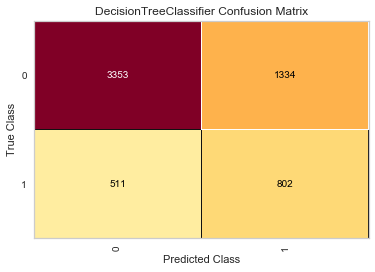

In [45]:
cm = ConfusionMatrix(best_tree, classes=[0, 1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

## Random Forest

In [49]:
ccd_rf = RandomForestClassifier(n_estimators=100, **dt_gs.best_params_)

In [51]:
ccd_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=25, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [93]:
y_preds = ccd_rf.predict(X_test)
recall_score(y_test, y_preds)

0.5712109672505712

In [92]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_preds)
print(auc(fpr, tpr)) # AUC of ROC

0.715518007627846


## XGBoost

In [87]:
ccd_xgb = xgb.XGBClassifier(objective='binary:hinge')

In [88]:
xgb_gs_params = {
    'max_depth':[5, 6, 7, 8, 10]
}

xgb_gs = GridSearchCV(ccd_xgb, xgb_gs_params, scoring='recall', n_jobs=-1, cv=3)

In [89]:
xgb_gs.fit(X_train, y_train);

In [90]:
y_preds_xgb = xgb_gs.predict(X_test)
recall_score(y_test, y_preds_xgb)

0.38309215536938307

## Logistic Regression

In [73]:
ccd_lr = LogisticRegression(solver='liblinear')

In [74]:
ccd_lr.fit(X_train, y_train);

In [85]:
y_preds_lr = ccd_lr.predict(X_test)
recall_score(y_test, y_preds_lr)

0.0

In [86]:
ccd_lr.score(X_test, y_test)

0.781